# Different edge sampling strategies for Link Prediction 

In [1]:
from NetworkAnalysis.UndirectedInteractionNetwork import UndirectedInteractionNetwork
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Useful functions

def summary_df_func(X, Y, degree_df, train_ratio, nw_obj, npr=5, traintest='train'):
    """AI is creating summary for summary_df_func

    Args:
        X ([type]): [description]
        Y ([type]): [description]
        degree_df ([type]): [description]
        train_ratio ([type]): [description]
        nw_obj ([type]): [description]
        npr (int, optional): [description]. Defaults to 5.
        traintest (str, optional): [description]. Defaults to 'train'.

    Returns:
        [type]: [description]
    """
    X_pos = X[np.where(Y == 1)[0]]
    X_neg = X[np.where(Y == 0)[0]]

    pos_genes, pos_counts = np.unique(X_pos.ravel(), return_counts=True)
    neg_genes, neg_counts = np.unique(X_neg.ravel(), return_counts=True)
    assert not set(pos_genes) - set(nw_obj.nodes), "Lost nodes pos"
    assert not set(neg_genes) - set(nw_obj.nodes), "Lost nodes neg"
    nodes_lost = set(nw_obj.nodes) - set(pos_genes)

    pos_df = degree_df.copy(deep=True)
    pos_df.loc[neg_genes, '#neg'] = neg_counts
    pos_df.loc[pos_genes, '#pos'] = pos_counts
    pos_df.loc[pos_df['#pos'].isna(), '#pos'] = pos_df[pos_df['#pos'].isna()]['Degree'].values
    if traintest == 'train':
        pos_df['Difference Negatives'] = ((pos_df['Degree'] * npr) * train_ratio).astype(int) - pos_df['#neg']
        pos_df['Difference Positives'] = (pos_df['Degree'] * train_ratio).astype(int) - pos_df['#pos']
    else:
        pos_df['Difference Negatives'] = ((pos_df['Degree'] * npr) * (1 - train_ratio)).astype(int) - pos_df['#neg']
        pos_df['Difference Positives'] = (pos_df['Degree'] * (1 - train_ratio)).astype(int) - pos_df['#pos']
    pos_df.sort_values('Degree', ascending=True, inplace=True)
    return pos_df, nodes_lost


def lineplot_summarydf(data1, title=None, data2=None, save_fp=None, subplots_titles=None, y_label=None):
    """AI is creating summary for lineplot_summarydf

    Args:
        data1 ([type]): [description]
        title ([type], optional): [description]. Defaults to None.
        data2 ([type], optional): [description]. Defaults to None.
        save_fp ([type], optional): [description]. Defaults to None.
        subplots_titles ([type], optional): [description]. Defaults to None.
        y_label ([type], optional): [description]. Defaults to None.
    """
    if data2 is not None:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
        sns.lineplot(data1, ax=ax1)
        sns.lineplot(data2, ax=ax2)
        ax1.set_xlabel('Gene')
        ax2.set_xlabel('Gene')
        if y_label is not None:
            ax1.set_ylabel(y_label)
        else:
            ax1.set_ylabel('Expected - Actual')
        ax1.set_title(subplots_titles[0])
        ax2.set_title(subplots_titles[1])
    else:
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(data1, ax=ax)
        ax.set_xlabel('Gene')
        if y_label is not None:
            ax.set_ylabel(y_label)
        else:
            ax.set_ylabel('Expected - Actual')

    if title is not None:
        fig.suptitle(title)

    if save_fp is None:
        plt.show()
    else:
        plt.savefig(save_fp, dpi=600, format="pdf")
        plt.close()

# Unbalanced Sampling

In [3]:
# Definition of hyperparameters
GRAPH_PATH = "/Users/jihwanlim/Documents/GitHub/GRL_practicum/data/reactome.txt"
train_ratio = 0.8
npr = 5 # This is the negative-to-positive ratio
seed = 23
balanced_sampling = False

In [6]:
reactome = pd.read_csv(GRAPH_PATH, sep='\t')
colnames = ['Gene1', 'Gene2'] # Select relevant columns from the edgelist
nw_obj = UndirectedInteractionNetwork(reactome, colnames=colnames, keeplargestcomponent=False)

13953 Nodes and 257629 interactions


Using unbalanced sampling


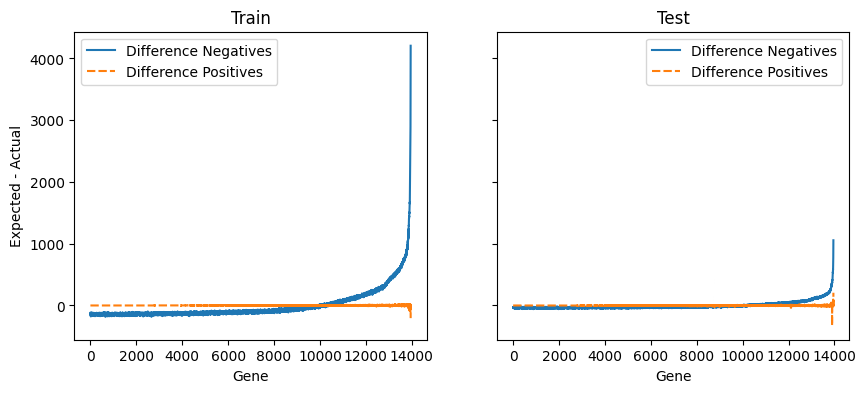

In [7]:

# Try Unbalanced sampling: args.balanced_sampling = 0
X_train, X_test, Y_train, Y_test, _ = nw_obj.getTrainTestData(train_ratio=train_ratio, neg_pos_ratio=npr, return_summary=True, random_state=23, balanced=balanced_sampling)

# Using the class method getDegreeDF(self, return_names=True, set_index=False) we obtain the degree of each node in the graph
degree_df = nw_obj.getDegreeDF(return_names=False)
degree_df.columns = ['Gene', 'Degree']

# Check degree distribution in training
pos_df_train, nodes_not_in_train = summary_df_func(X=X_train, Y=Y_train, degree_df=degree_df, nw_obj=nw_obj, train_ratio=train_ratio)

assert not nodes_not_in_train,"Error: Nodes lost in training set"

# Check degree distribution in testing
pos_df_test, nodes_lost = summary_df_func(X=X_test, Y=Y_test, degree_df=degree_df, nw_obj=nw_obj, train_ratio=train_ratio, traintest='test')

lineplot_summarydf(data1=pos_df_train[['Difference Negatives', 'Difference Positives']].reset_index(drop=True),
                    data2=pos_df_test[['Difference Negatives', 'Difference Positives']].reset_index(drop=True),
                    title=None, subplots_titles=["Train", "Test"], save_fp=None)


# Balanced Sampling

Using balanced sampling
Not enough negatives available for gene RAD17
Not enough negatives available for gene DDIT3
Not enough negatives available for gene EGLN1
Not enough negatives available for gene OPRM1
Not enough negatives available for gene RAD9A
Not enough negatives available for gene ZNF830
Not enough negatives available for gene CCND2
Not enough negatives available for gene KPNA1
Not enough negatives available for gene MTA3
Not enough negatives available for gene TAF4


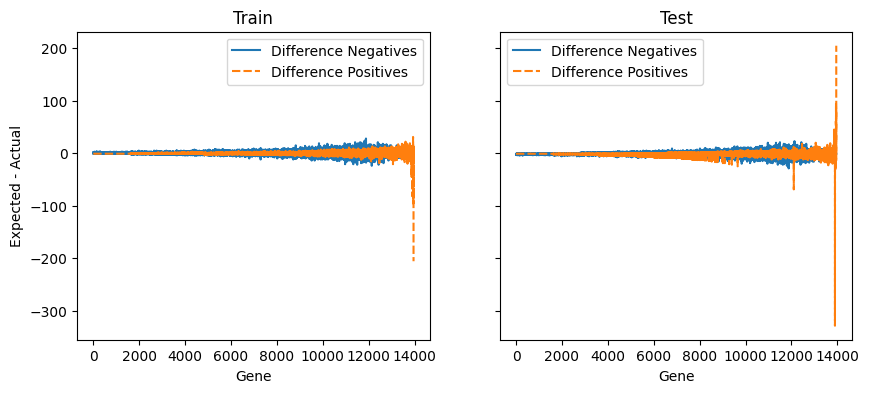

In [8]:
# Try Unbalanced sampling: balanced_sampling = 0
balanced_sampling = 1

X_train, X_test, Y_train, Y_test, _ = nw_obj.getTrainTestData(train_ratio=train_ratio, neg_pos_ratio=npr, return_summary=True, random_state=23, balanced=balanced_sampling)

# Using the class method getDegreeDF(self, return_names=True, set_index=False) we obtain the degree of each node in the graph
degree_df = nw_obj.getDegreeDF(return_names=False)
degree_df.columns = ['Gene', 'Degree']

# Check degree distribution in training
pos_df_train, nodes_not_in_train = summary_df_func(X=X_train, Y=Y_train, degree_df=degree_df, nw_obj=nw_obj, train_ratio=train_ratio)

assert not nodes_not_in_train,"Error: Nodes lost in training set"

# Check degree distribution in testing
pos_df_test, nodes_lost = summary_df_func(X=X_test, Y=Y_test, degree_df=degree_df, nw_obj=nw_obj, train_ratio=train_ratio, traintest='test')

lineplot_summarydf(data1=pos_df_train[['Difference Negatives', 'Difference Positives']].reset_index(drop=True),
                    data2=pos_df_test[['Difference Negatives', 'Difference Positives']].reset_index(drop=True),
                    title=None, subplots_titles=["Train", "Test"], save_fp=None)